# Coarsened heatmaps for cirrus counts
at the cold point level

In [7]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts/")
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import model_grid as mg
import get_d2_data as get_d2

from matplotlib.gridspec import GridSpec


In [8]:
file_path = "/work/bb1153/b380887/global_tropics/"
new_thresh_path = file_path + "cirrus_frequencies/4e-6/"

pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/cirrus_freqs/"


In [37]:
model_list = ["SHIELD", "GEOS", "SCREAM", "SAM", "ICON"]


#### For observations: OBS_cp_cirrus_counts_at_zcp.nc is already 5x5!

In [38]:
def coarsen_ci(ci, boundary="pad", return_xy=False):
    """ 
    Coarsen the lat/lon dataset to 5x5 by taking the count.
    Pad instead of trimming excess values so you don't lose information
    """
    dx = 360/len(ci.lon)
    dy = 40/len(ci.lat)

    xcoarse = int(np.round(5/dx, 0))
    ycoarse = int(np.round(5/dy, 0))

    ci_nz = ci.where(ci > 0)
    ci_coarse = ci_nz.coarsen({"lat": xcoarse, "lon": ycoarse}, boundary=boundary).count()
    
    if return_xy:
        return ci_coarse, xcoarse, ycoarse
    else:
        return ci_coarse


In [34]:
xcoarse = int(np.round(5/dx, 0))
ycoarse = int(np.round(5/dy, 0))

In [39]:
def get_dict(model_list, file_path, layer, return_xy=False):
    """ Get the dictionary mapping models to count data arrays
    """
    layer_dict = {}
    layer_dict_ptw = {}
    x_dict = {}
    y_dict = {}
    
    for model in model_list:
        counts = get_d2.get_ci(model, file_path, layer)["ci_count"]
        ci = get_d2.interp_var2d(counts, model, pickle_dir, has_cell_coords=False)
        if return_xy:
            layer_dict[model], x_dict[model], y_dict[model] = coarsen_ci(ci, return_xy=return_xy)
        else:
            layer_dict[model] = coarsen_ci(ci, return_xy=return_xy)
        layer_dict_ptw[model] = ci
        print("\n")
    
    if return_xy:
        return layer_dict, layer_dict_ptw, x_dict, y_dict
    else:
        return layer_dict, layer_dict_ptw


In [40]:
%%time

# at_dict, at_dict_ptw, x, y = get_dict(model_list, file_path, "at", return_xy=True)
# above_dict, above_dict_ptw = get_dict(model_list, file_path, "above")
# below_dict, below_dict_ptw = get_dict(model_list, file_path, "below")

cp_dict, cp_dict_ptw, x, y = get_dict(model_list, new_thresh_path, "at_zcp", return_xy=True)



Interpolating SHIELD
Creating dummy grid...
913840 grid points (5.20%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.


Interpolating GEOS
Creating dummy grid...
687985 grid points (4.46%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.


Interpolating SCREAM
Creating dummy grid...
592760 grid points (7.22%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.


SAM already has lat/lon coordinates; no interpolation needed


Interpolating ICON
Creating dummy grid...
317030 grid points (1.12%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.


CPU times: user 2min 51s, sys: 8.04 s, total: 2min 59s
Wall time: 3min 10s


OBS was wrong here - ignore!

In [7]:
for model in model_list:
    cell_count_dict = {
        "x": x[model],
        "y": y[model],
        "xy": x[model]*y[model]
    }
    print(cell_count_dict)
    with open(pickle_dir + "cell_counts_5x5/{m}_cell_counts_5x5_dict.pickle".format(m=model), "wb") as handle:
        pickle.dump(cell_count_dict, handle)
    

{'x': 1, 'y': 1, 'xy': 1}
{'x': 170, 'y': 170, 'xy': 28900}
{'x': 160, 'y': 160, 'xy': 25600}
{'x': 115, 'y': 115, 'xy': 13225}
{'x': 128, 'y': 133, 'xy': 17024}
{'x': 220, 'y': 220, 'xy': 48400}


### Save the coarsened files to make creating plots easier for the paper/poster

In [9]:
# check out max & mean counts within the 5x5 boxes
for model in model_list:
    ci_nz = cp_dict[model].where(cp_dict[model] > 0)
    print(model, ci_nz.max().values, ci_nz.mean().values)


SHIELD 28900.0 12751.909456740443
GEOS 25600.0 7498.399585921325
SCREAM 13225.0 6719.354901960784
SAM 17017.0 5121.078544061303
ICON 47900.0 13018.173333333334


OBS wrong here too!

In [8]:
# check out max & mean counts within the 5x5 boxes
for model in model_list:
    ci_nz = cp_dict[model].where(cp_dict[model] > 0)
    print(model, ci_nz.max().values, ci_nz.mean().values)


OBS 1.0 1.0
SHIELD 28900.0 11290.7004048583
GEOS 25598.0 6945.709251101322
SCREAM 13225.0 5199.387878787878
SAM 16910.0 4307.685831622177
ICON 46983.0 11293.13875598086


In [9]:
def save_coarse(layer, model, file_path, ci_dict):
    """ Save the coarsened files as a netcdf 
    """
    if layer == "above": 
        layer_ext = "0_to_a1000"
    elif layer == "at": 
        layer_ext = "b500_to_a500"
    elif layer == "below":
        layer_ext = "b1000_to_0"
    elif layer == "at_zcp":
        layer_ext = "at_zcp"
    else:
        raise Exception("Input `layer` must be \"above\" (zcp to +1000m), \"below\" (-1000m to zcp), or \"at\" (-500m to +500m) OR \"at_zcp\" (zcp)")
        
    out_name = file_path + "cirrus_frequencies/{m}_cirrus_counts_5x5_{e}.nc".format(m=model, e=layer_ext)
    if model != "SAM":
        ci_dict[model] = ci_dict[model].rename( "ci_count")
    ci_dict[model].to_netcdf(out_name)
    

In [12]:
def save_not_coarse(layer, model, file_path, ci_dict):
    """ Save the coarsened files as a netcdf 
    """
    if layer == "above": 
        layer_ext = "0_to_a1000"
    elif layer == "at": 
        layer_ext = "b500_to_a500"
    elif layer == "below":
        layer_ext = "b1000_to_0"
    elif layer == "at_zcp":
        layer_ext = "at_zcp"
    else:
        raise Exception("Input `layer` must be \"above\" (zcp to +1000m), \"below\" (-1000m to zcp), or \"at\" (-500m to +500m) OR \"at_zcp\" (zcp)")
        
    out_name = file_path + "cirrus_frequencies/{m}_cirrus_counts_pointwise_{e}.nc".format(m=model, e=layer_ext)
    if model != "SAM":
        ci_dict[model] = ci_dict[model].rename( "ci_count")
    ci_dict[model].to_netcdf(out_name)
    

In [11]:
for model in model_list:
    # save_coarse("above", model, file_path, above_dict)
    # save_coarse("at", model, file_path, at_dict)
    # save_coarse("below", model, file_path, below_dict)
    # save_not_coarse("above", model, file_path, above_dict_ptw)
    # save_not_coarse("at", model, file_path, at_dict_ptw)
    # save_not_coarse("below", model, file_path, below_dict_ptw)
    save_coarse("at_zcp", model, file_path, cp_dict)
    save_not_coarse("at_zcp", model, file_path, cp_dict_ptw)


## Basic plots

In [41]:
def basic_plot(model_list, layer_dict, layer, save=False, coarse=True, vmax=5e4,
               vmin=1, freq=False, nt=240.):
    """ Basic coarsened cirrus heatmap plot for all models
    """
    for model in model_list:
        fig, ax = plt.subplots(figsize=(18, 3))
        ci_coarse_nz = layer_dict[model].where(layer_dict[model] > 0)
        if freq:
            ci_coarse_nz = ci_coarse_nz*100./nt
        pcm = ax.pcolormesh(ci_coarse_nz.lon, ci_coarse_nz.lat, ci_coarse_nz, cmap="Spectral_r",
                           norm=mcolors.LogNorm(vmin=vmin, vmax=vmax))
        plt.colorbar(pcm, ax=ax, orientation="horizontal")
        ax.set_title(model + " " + layer, fontsize=16)
        ax.tick_params(axis="both", labelsize=14)

        if save:
            if coarse:
                plt.savefig(save_dir + "{m}_draft_cirrus_heatmap_{l}.png".format(m=model, l=layer), dpi=300, bbox_inches="tight")
            else:
                plt.savefig(save_dir + "{m}_draft_cirrus_heatmap_pointwise_{l}.png".format(m=model, l=layer), dpi=300, bbox_inches="tight")

        plt.show()


In [14]:
cp_dict = {}

#### note - these are COUNTS, not frequencies

In [42]:
# ci_path = file_path + "cirrus_frequencies/"
ci_path = new_thresh_path
plot_model_list = ["OBS", "SHIELD", "SAM", "GEOS", "SCREAM", "ICON"] 

for model in plot_model_list:
    # at_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_b500_to_a500.nc".format(m=model))["ci_count"]
    # below_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_b1000_to_0.nc".format(m=model))["ci_count"]
    # above_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_0_to_a1000.nc".format(m=model))["ci_count"]
    cp_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_at_zcp.nc".format(m=model))["ci_count"]
cp_dict["OBS"] = cp_dict["OBS"].T


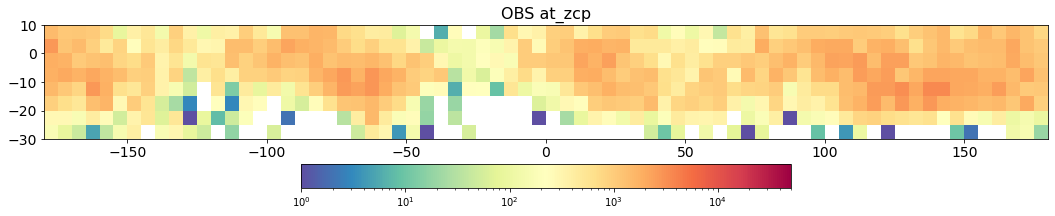

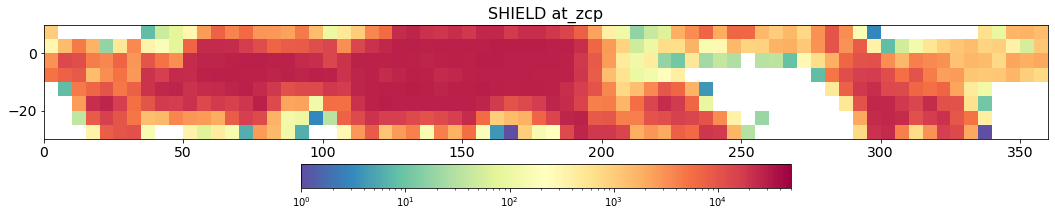

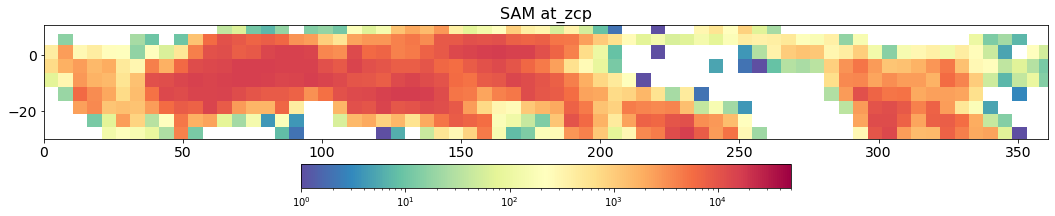

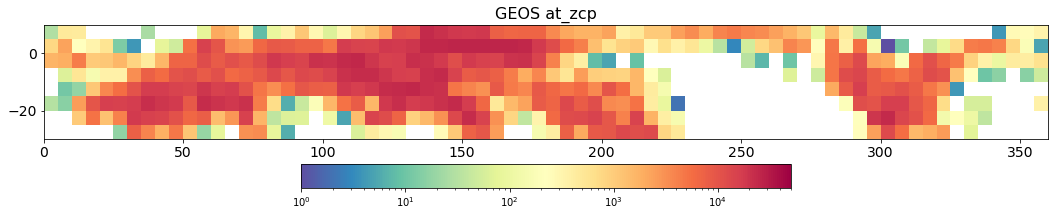

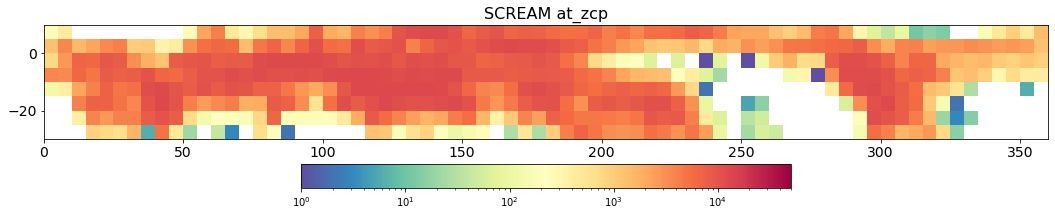

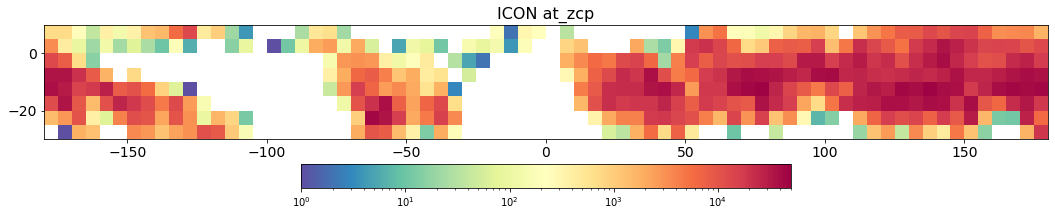

In [43]:
basic_plot(plot_model_list, cp_dict, "at_zcp", save=True, vmax=5e4)


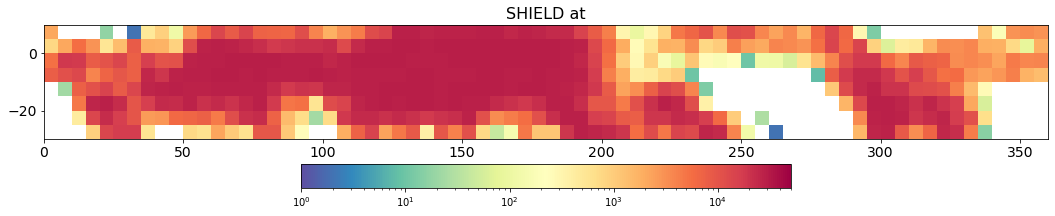

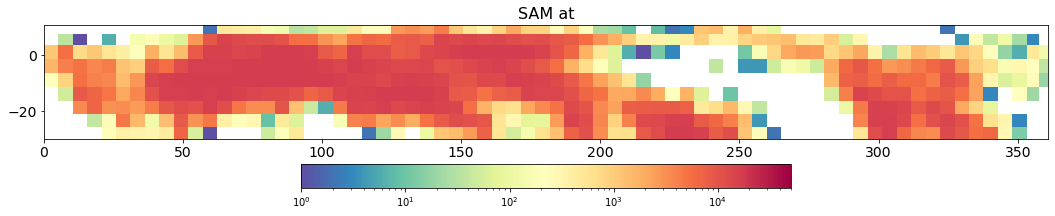

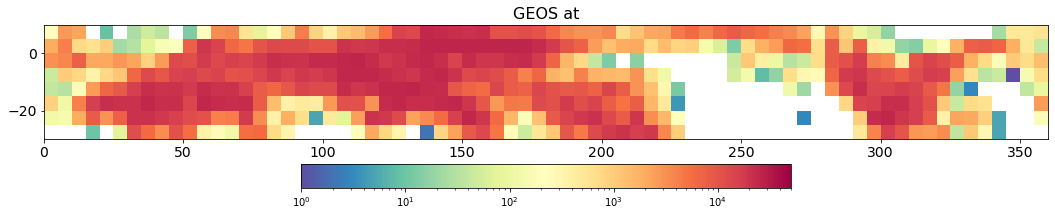

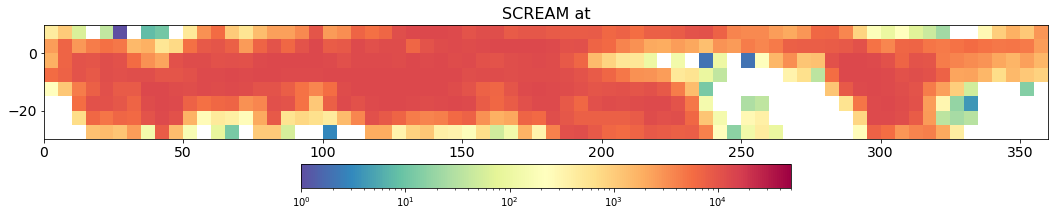

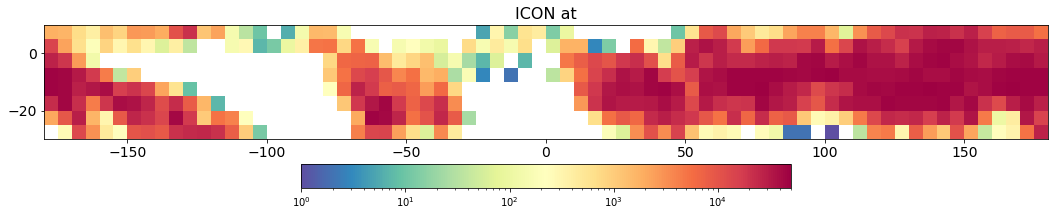

In [16]:
basic_plot(plot_model_list, at_dict, "at", save=True, vmax=5e4)


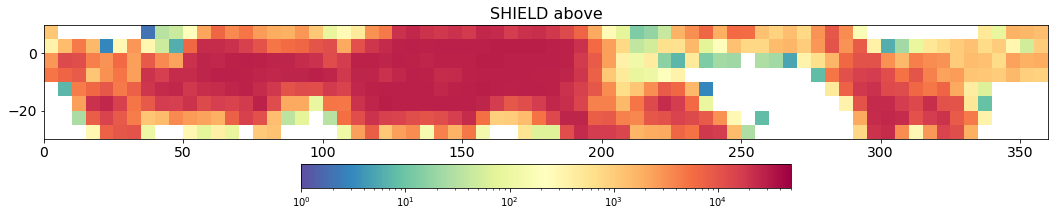

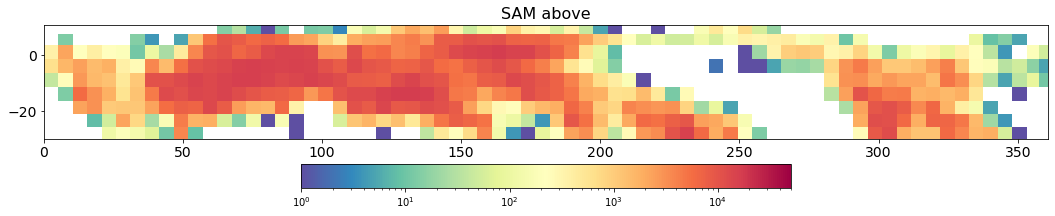

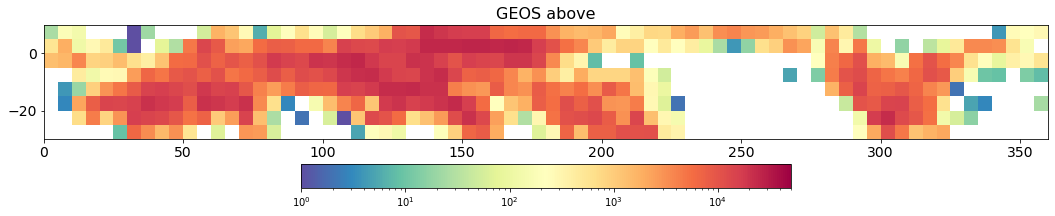

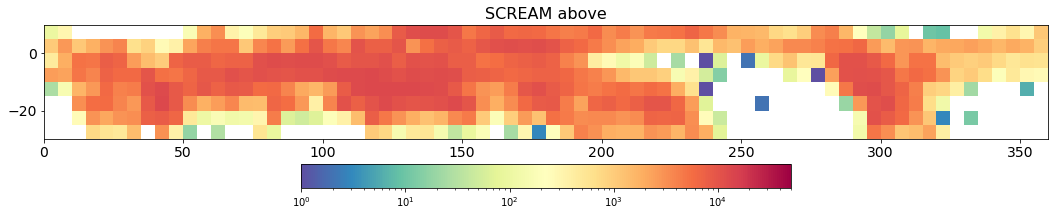

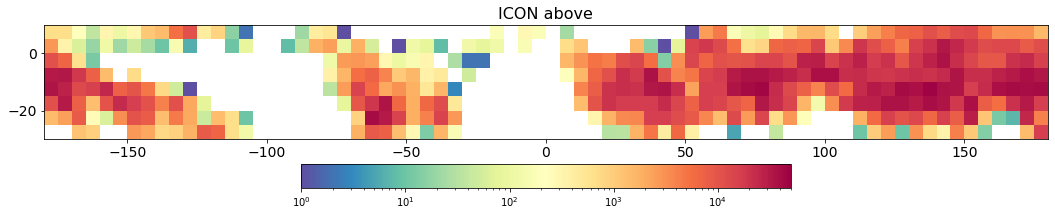

In [17]:
basic_plot(plot_model_list, above_dict, "above", save=True, vmax=5e4)


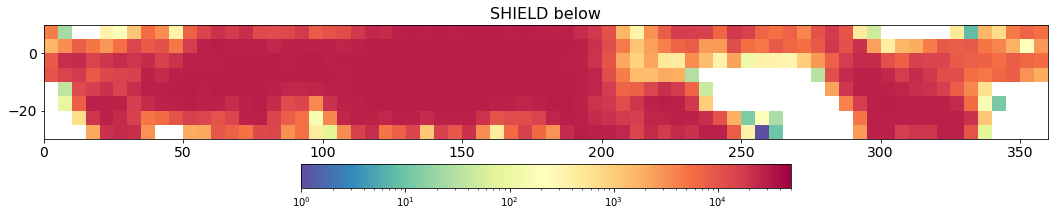

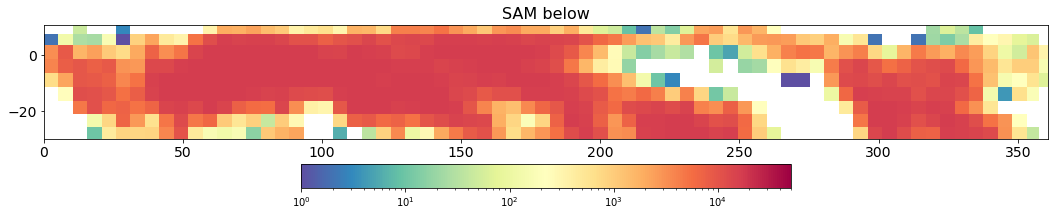

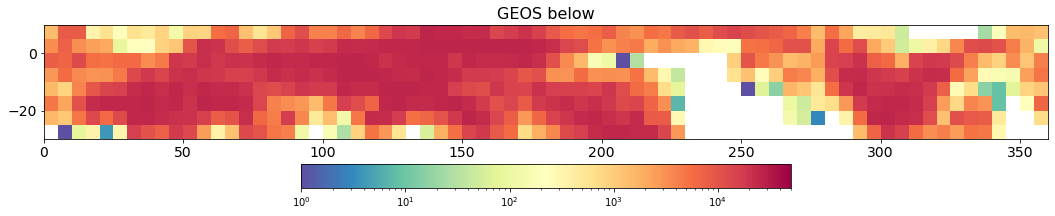

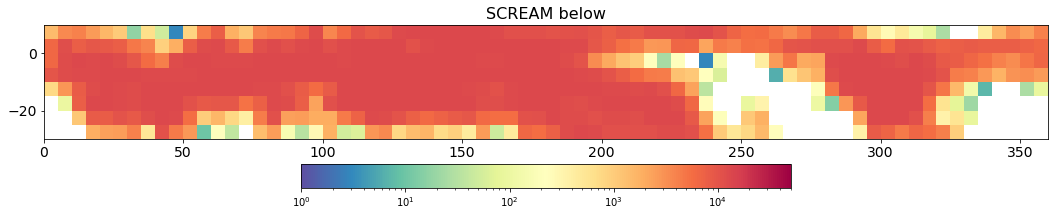

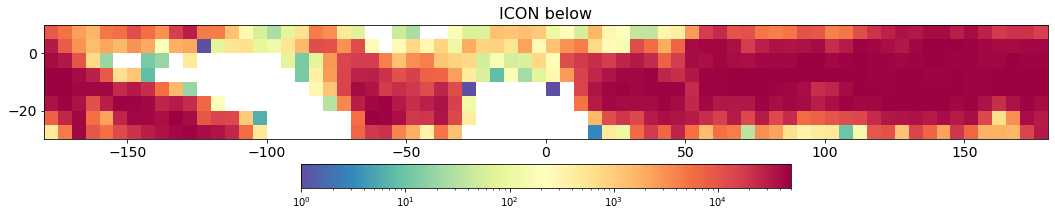

In [18]:
basic_plot(plot_model_list, below_dict, "below", save=True, vmax=5e4)


### NOT COARSENED:

In [18]:
def get_dict_not_coarse(model_list, file_path, layer, save_xy=False):
    """ Get the dictionary mapping models to count data arrays
    """
    layer_dict = {}
    
    for model in model_list:
        counts = get_d2.get_ci(model, file_path, layer)["ci_count"]
        ci = get_d2.interp_var2d(counts, model, pickle_dir, has_cell_coords=False)
        if save_xy:
            _, x, y = coarsen_ci(ci, return_xy=True)
        layer_dict[model] = ci
    
        if save_xy:
            cell_count_dict = {
                "x": x,
                "y": y,
                "xy": x*y
            }
            print(cell_count_dict)
            with open(pickle_dir + "cell_counts_5x5/{m}_cell_counts_5x5_dict.pickle".format(m=model), "wb") as handle:
                pickle.dump(cell_count_dict, handle)
        
    return layer_dict


In [19]:
plot_model_list = ["SHIELD", "SAM", "GEOS", "SCREAM", "ICON"]


In [20]:
vmax_ptw = 50
vmin_ptw = 1


In [15]:
# %%time

# at_dict_ptw = get_dict_not_coarse(plot_model_list, file_path, "at", save_xy=True)
# above_dict_ptw = get_dict_not_coarse(plot_model_list, file_path, "above")
# below_dict_ptw = get_dict_not_coarse(plot_model_list, file_path, "below")


Interpolating SHIELD
Creating dummy grid...
913840 grid points (5.20%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.
{'x': 170, 'y': 170, 'xy': 28900}
SAM already has lat/lon coordinates; no interpolation needed
{'x': 128, 'y': 133, 'xy': 17024}
Interpolating GEOS
Creating dummy grid...
687985 grid points (4.46%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.
{'x': 160, 'y': 160, 'xy': 25600}
Interpolating SCREAM
Creating dummy grid...
592760 grid points (7.22%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.
{'x': 115, 'y': 115, 'xy': 13225}
Interpolating ICON
Creating dummy grid...
317030 grid points (1.12%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.
{'x': 220, 'y': 220, 'xy': 48400}
Interpolating SHIELD
Creating dummy grid...
913840 grid points (5.20%) will be lost from interpolation.
Dummy grid done.


In [21]:
ci_path = file_path + "cirrus_frequencies/"
plot_model_list = ["SHIELD", "SAM", "GEOS", "SCREAM", "ICON"] 

for model in plot_model_list:
    # at_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_b500_to_a500.nc".format(m=model))["ci_count"]
    # below_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_b1000_to_0.nc".format(m=model))["ci_count"]
    # above_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_5x5_0_to_a1000.nc".format(m=model))["ci_count"]
    cp_dict[model] = xr.open_dataset(ci_path + "{m}_cirrus_counts_pointwise_at_zcp.nc".format(m=model))["ci_count"]


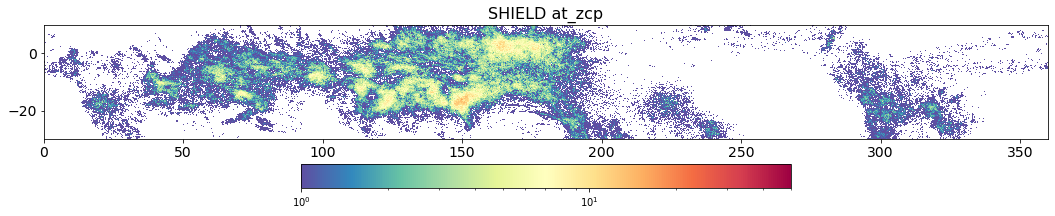

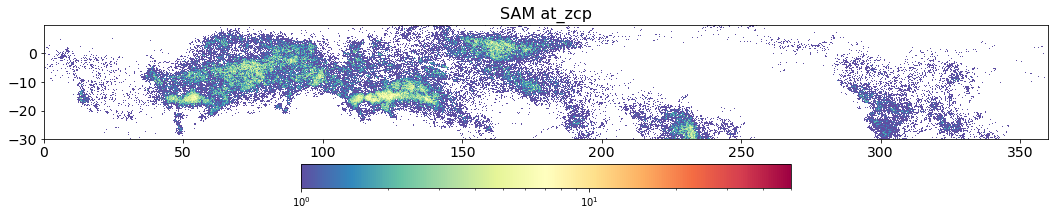

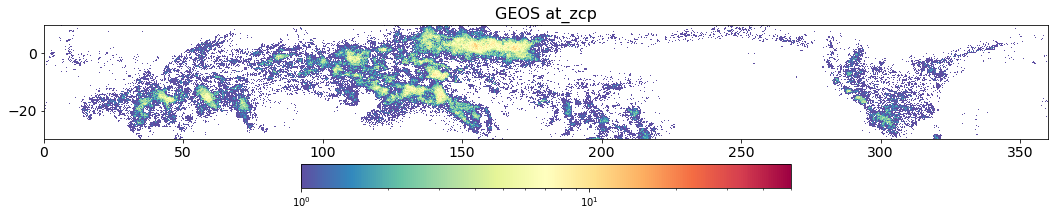

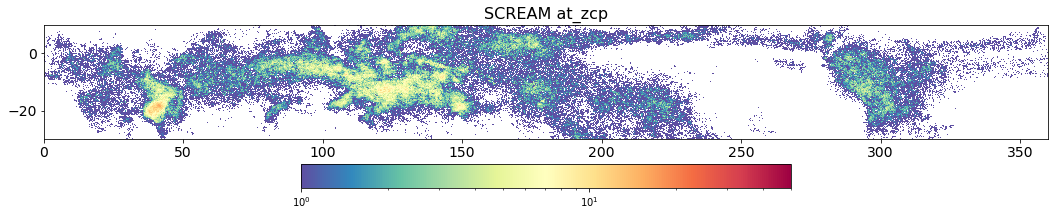

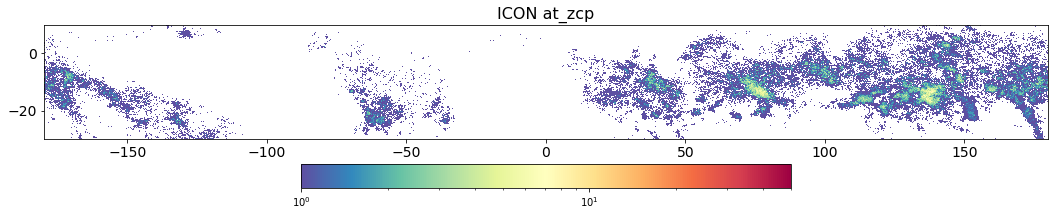

In [22]:
basic_plot(plot_model_list, cp_dict, "at_zcp", save=True, coarse=False, 
           vmax=vmax_ptw, vmin=vmin_ptw, freq=True)


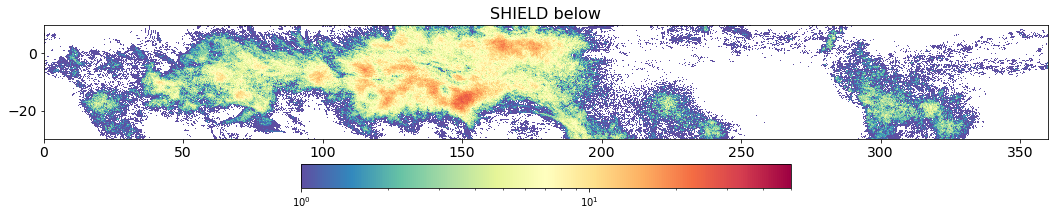

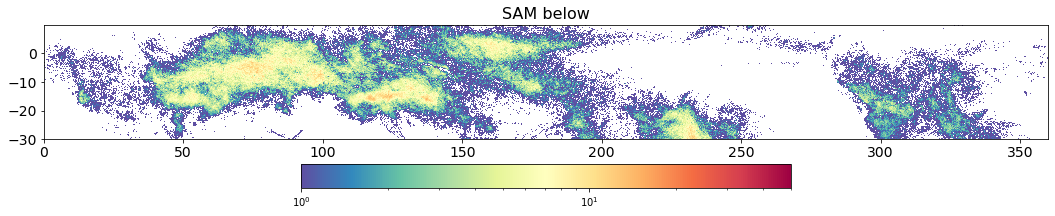

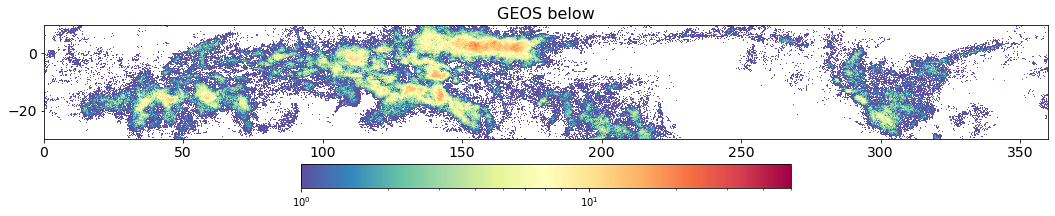

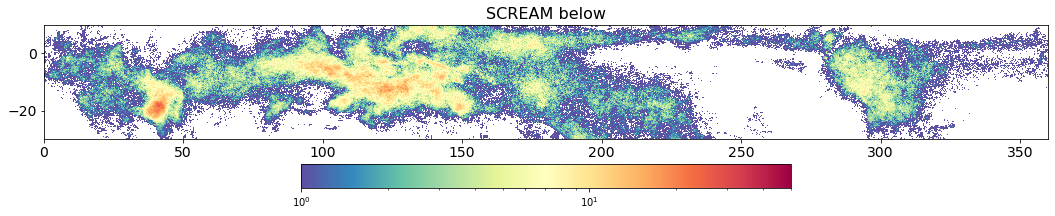

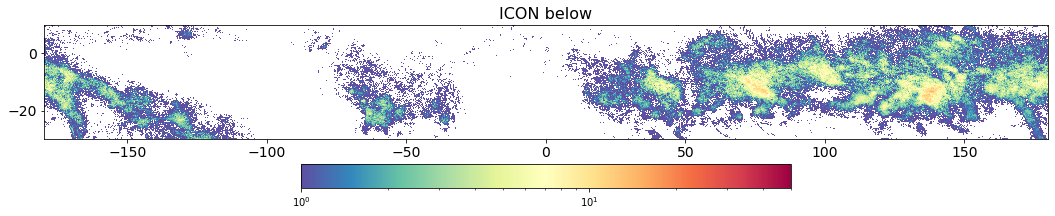

In [20]:
basic_plot(plot_model_list, below_dict_ptw, "below", save=True, coarse=False, 
           vmax=vmax_ptw, vmin=vmin_ptw, freq=True)


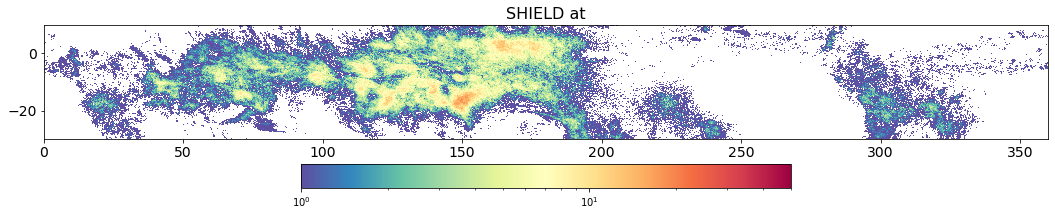

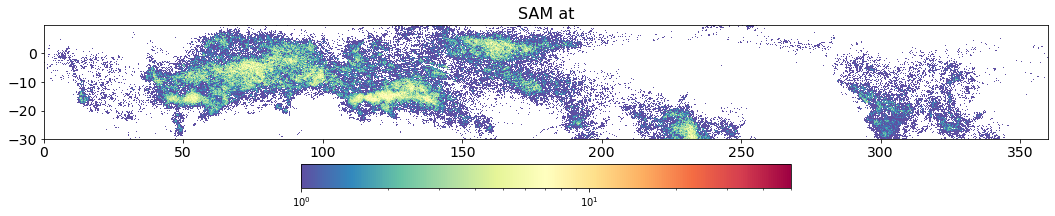

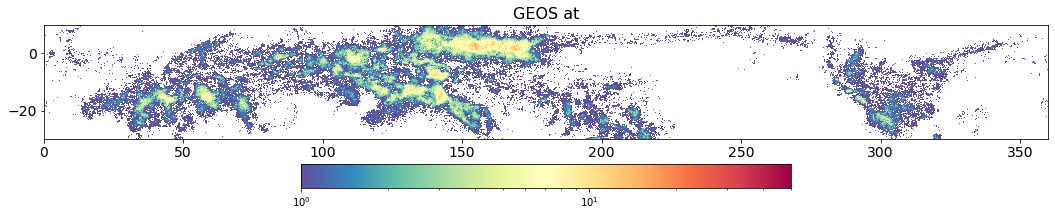

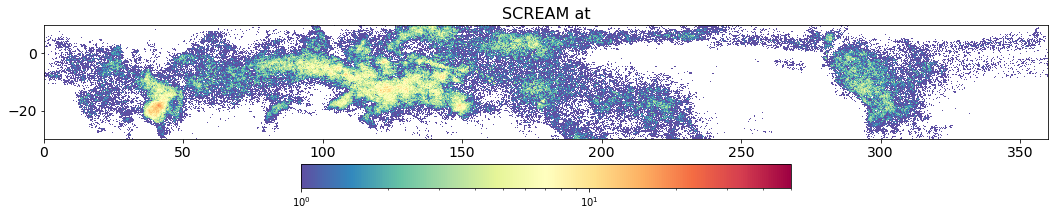

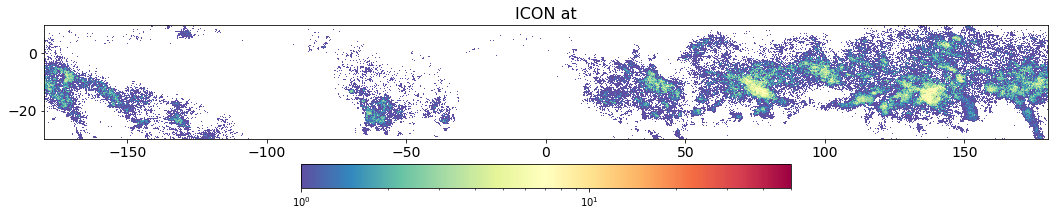

In [21]:
basic_plot(plot_model_list, at_dict_ptw, "at", save=True, coarse=False,
           vmax=vmax_ptw, vmin=vmin_ptw,  freq=True)


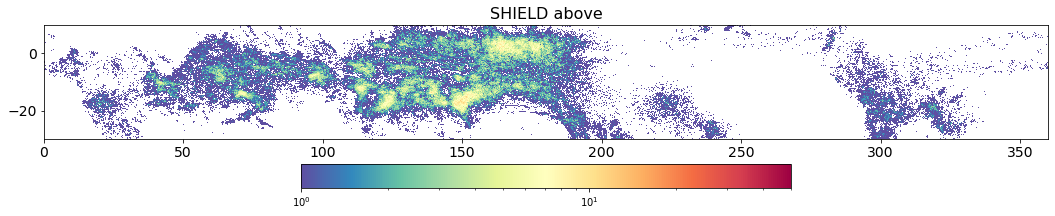

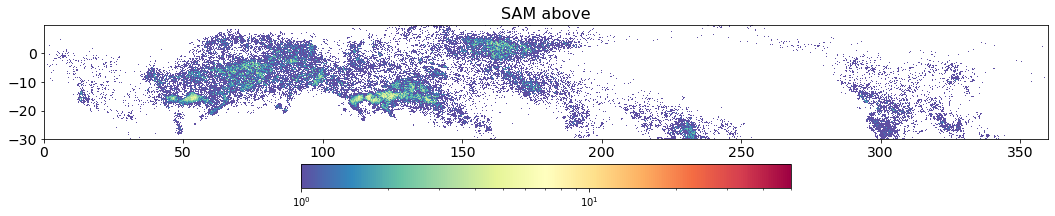

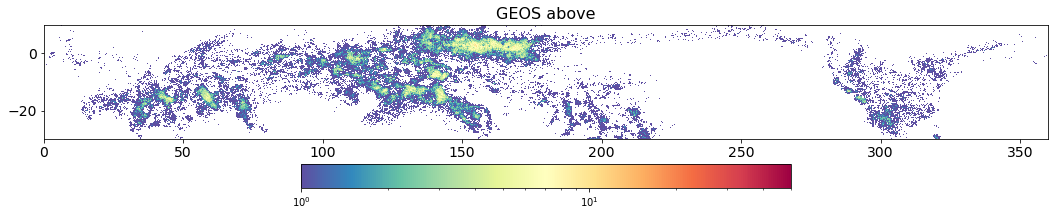

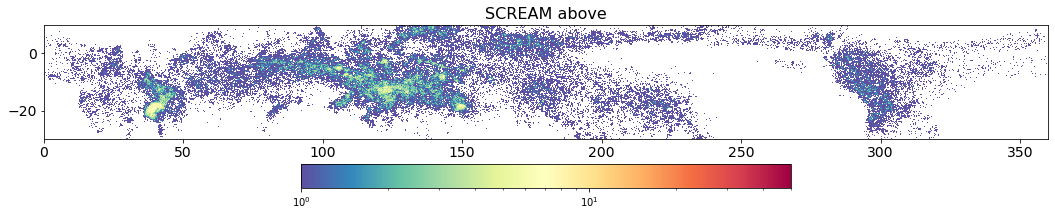

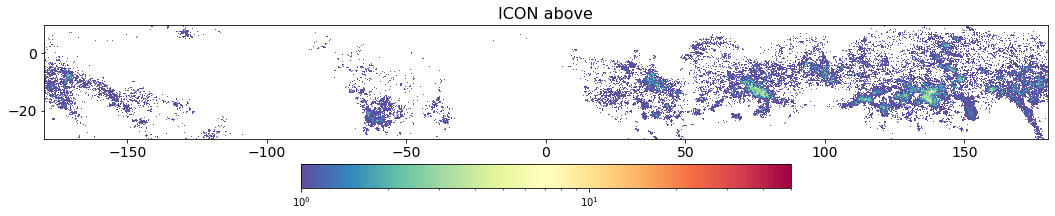

In [22]:
basic_plot(plot_model_list, above_dict_ptw, "above", save=True, coarse=False, 
           vmax=vmax_ptw, vmin=vmin_ptw,  freq=True)


## Pretty plots
Match the os frequency plots - do this in a separate notebook later!

In [23]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec

In [24]:
sca_coords = [20, 30, -17, -7]
tim_coords = [120, 130, -12, -2]
spc_coords = [170, 180, -15, -5]
amz_coords = [-65, -55, -30, -20]
coords_dict = {
    "SCA": sca_coords,
    "TIM": tim_coords,
    "SPC": spc_coords,
    "AMZ": amz_coords
}


In [25]:
def plot_ci_heatmap(os_counts, model, coords_dict, cmap="Spectral_r", save_dir=save_dir,
                    mask_min=True, fsize=16, tsize=24, labsize=14, vmin=1, vmax=50, vint=0.5, figsize=(17, 4), levels=None,
                    central_lon=80, save=False, annotate_regions=False, plot_colorbar=True, region_color="k",
                      alpha=1, count=True, lognorm=True):
    """Plot the heatmap after it's been calculated
    """
    plot_lons = [*np.arange(-100, 181, 40), *np.arange(-140, -99, 40)]
    plot_lats = np.arange(-30, 11, 10)
    
    # setup
    if levels is None:
        levels = np.arange(vmin, vmax+vint/2, vint)
            
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 6, height_ratios=[0.075, 1, 0.15], hspace=0.3, wspace=0.4)
    ax_cb_cp = plt.subplot(gs[2, 1:5])
    ax_cp = plt.subplot(gs[1, :], projection=ccrs.PlateCarree(central_longitude=central_lon))
    ax_title = plt.subplot(gs[0, :])
    if not plot_colorbar:
        ax_cb_cp.axis("off")

    # -central_lon is an artifical offset to get the plotting longitudes aligned correctly with cartopy & pcolormesh
    os_counts_nz = os_counts.where(os_counts > 0)
    if model == "ICON":
        lons = os_counts_nz.lon % 360
    else:
        lons = os_counts_nz.lon
    if lognorm:
        pcm = ax_cp.pcolormesh(lons-central_lon, os_counts_nz.lat, os_counts_nz, cmap=cmap,
                           norm=mcolors.LogNorm(vmin=vmin, vmax=vmax), alpha=alpha)
    else:
        pcm = ax_cp.pcolormesh(lons-central_lon, os_counts_nz.lat, os_counts_nz, cmap=cmap,
                               vmin=vmin, vmax=vmax, alpha=alpha)

    # add region borders
    for region in list(coords_dict.keys()):
        coords = coords_dict[region]
        ax_cp.add_patch(mpatches.Rectangle(xy=[coords[0], coords[2]], 
                                        width=10, 
                                        height=10,
                                        fill=False, color=region_color, linewidth=5,
                                        transform=ccrs.PlateCarree()
                                       ))        

    # gridlines
    gl = ax_cp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        xlocs=plot_lons, ylocs=plot_lats, x_inline=False, y_inline=False, color = "None")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labsize, 'rotation': 0}#20}
    gl.ylabel_style = {'size': labsize}
    ax_cp.add_feature(cfeature.COASTLINE, linewidth=2)
    ax_cp.set_ylim((plot_lats[0], plot_lats[-1]))

    # colorbar
    if plot_colorbar:
        cbar_cp = plt.colorbar(pcm, cax=ax_cb_cp, orientation="horizontal", extend="max")#, format='%.0f')
        if count:
            cbar_cp.set_label("Cold point overshoot count (5°x5°)", fontsize=fsize)
        else:
            cbar_cp.set_label("Pointwise radiatively active cirrus frequency (%)", fontsize=fsize)
        cbar_cp.ax.tick_params(labelsize=labsize)
    
    # titles
    ax_title.axis("off")
    ax_title.text(x=0.5, y=0, s=model, verticalalignment="center_baseline",
                  horizontalalignment="center", fontsize=tsize+5
                  )

    if save:
        if not lognorm:
            ln = "_linear_colors"
        else:
            ln = ""
        plt.savefig(save_dir + "{m}_quick_ci_heatmap_pointwise.png".format(m=model, n=ln), bbox_inches="tight", dpi=300)

    plt.show()


### These are counts!

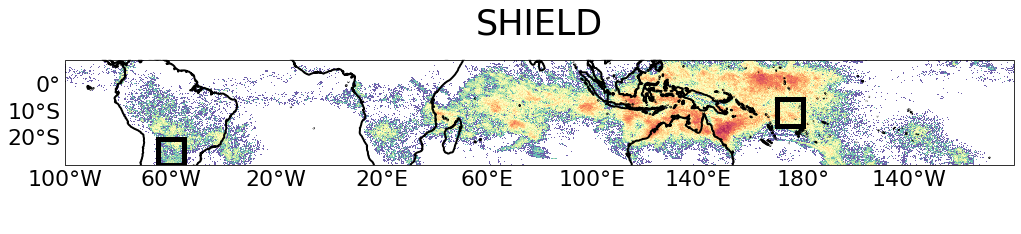

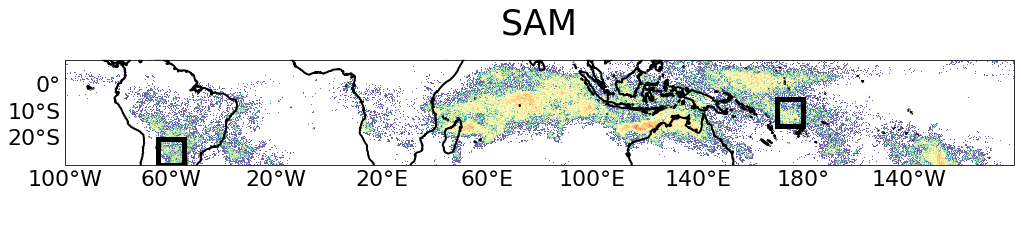

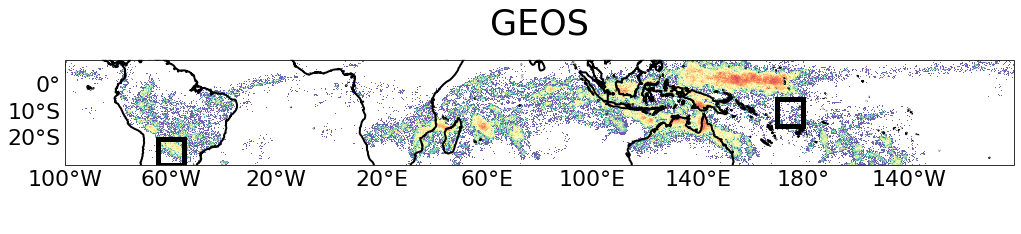

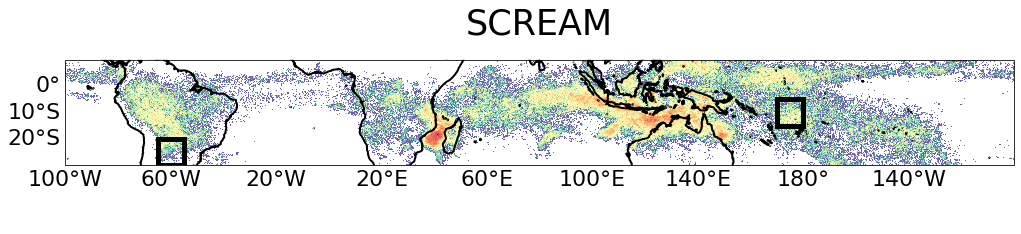

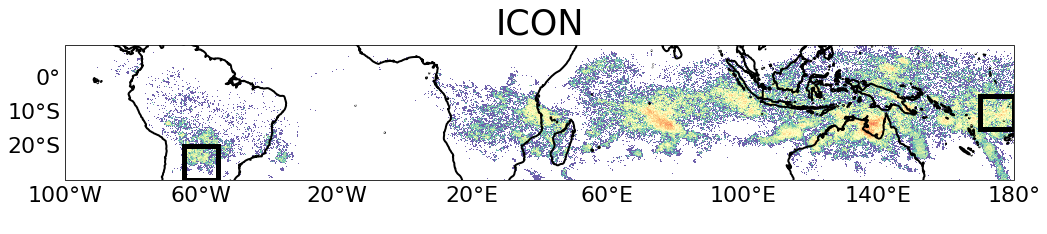

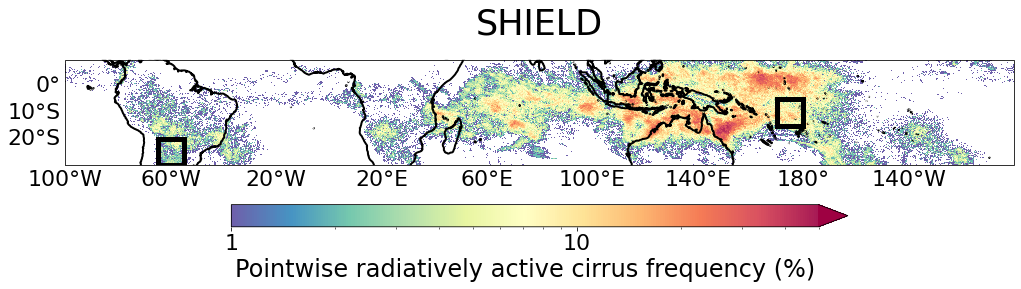

In [41]:
for model in plot_model_list:
    plot_ci_heatmap(at_dict_ptw[model], model, coords_dict, plot_colorbar=False,
                      labsize=22, fsize=24, tsize=30, region_color="k", alpha=0.9,
                      save=True, cmap="Spectral_r", count=False, #vmin=0.1, vmax=10,
                      )
    
plot_ci_heatmap(at_dict_ptw["SHIELD"], "SHIELD", coords_dict, plot_colorbar=True,
                      labsize=22, fsize=24, tsize=30, region_color="k", alpha=0.9,
                      save=True, cmap="Spectral_r", count=False) #vmin=0.1, vmax=10)
                            


In [11]:
plot_model_list

['SHIELD', 'SAM', 'GEOS', 'SCREAM', 'ICON']

# Try this for the os frequencies... small numbers, but that's okay!

In [20]:
ci_freq_dict = {}

for model in plot_model_list:
    # out_name = file_path + "cirrus_frequencies/{m}_cp_cirrus_counts_b500_to_a500.nc".format(m=model)
    out_name = file_path + "cirrus_frequencies/{m}_cirrus_counts_5x5_b500_to_a500.nc".format(m=model)
    count = xr.open_dataset(out_name)["ci_count"]
    with open(pickle_dir + "cell_counts_5x5/{m}_cell_counts_5x5_dict.pickle".format(m=model), "rb") as handle:
        xy = pickle.load(handle)["xy"]
    print(count.max().values)
    if model == "OBS":
        freq = count / 224. / xy
    else:
        freq = count / 240. / xy
    ci_freq_dict[model] = freq
    

28900
17024
25600
13225
48353


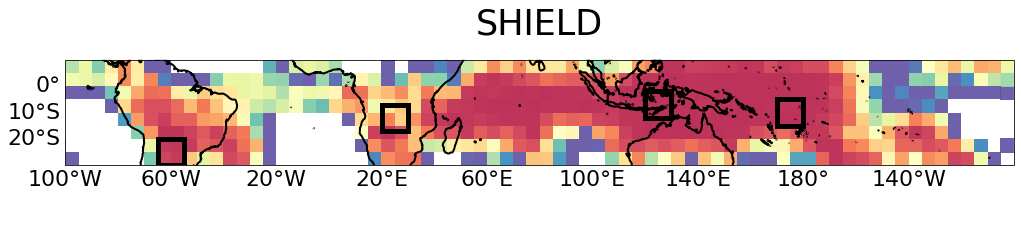

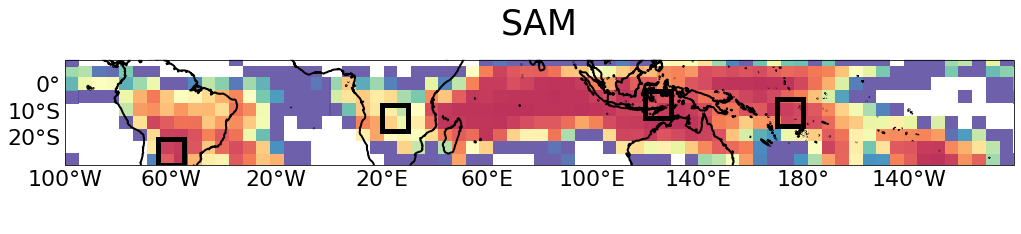

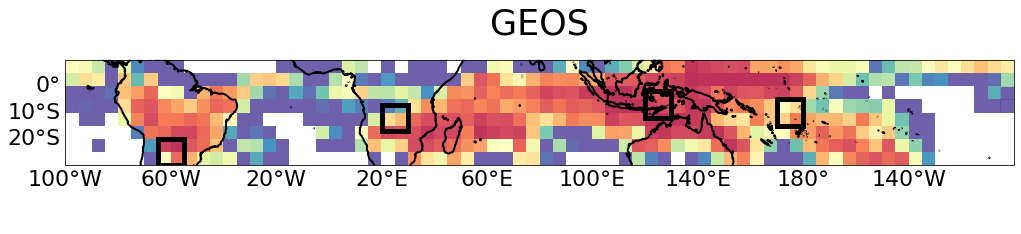

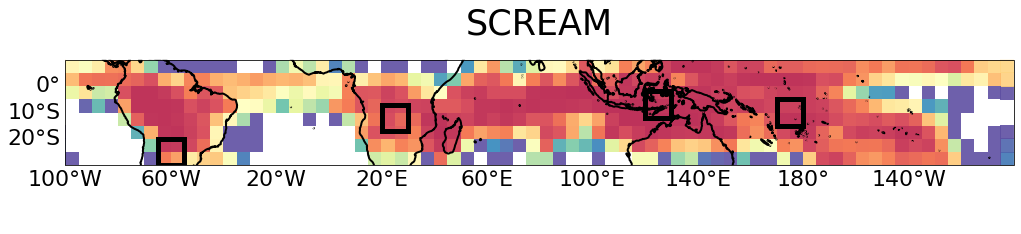

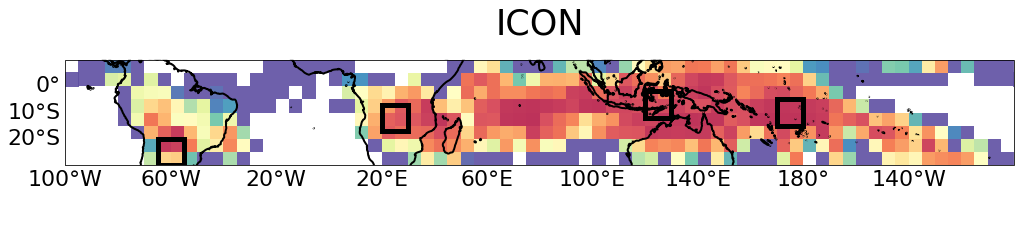

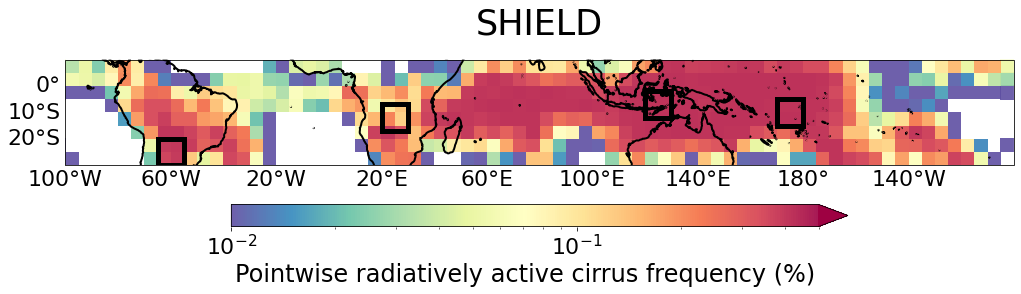

In [38]:
for model in plot_model_list:
    plot_ci_heatmap(ci_freq_dict[model]*100., model, coords_dict, plot_colorbar=False,
                      labsize=22, fsize=24, tsize=30, region_color="k", alpha=0.9,
                      save=False, cmap="Spectral_r", count=False, vmin=0.01, vmax=0.5,
                      )
    
plot_ci_heatmap(ci_freq_dict["SHIELD"]*100., "SHIELD", coords_dict, plot_colorbar=True,
                      labsize=22, fsize=24, tsize=30, region_color="k", alpha=0.9,
                      save=False, cmap="Spectral_r", count=False, vmin=0.01, vmax=0.5)
                            
